In [1]:
import os, sys

# Open a file
VCB_PATH = "/home/ubuntu/data/voxceleb1_wav"
names = [d for d in os.listdir(VCB_PATH) if os.path.isdir(os.path.join(VCB_PATH, d))]

audio_clips = {}
for name in names:
    audio_clips[name] = os.listdir(VCB_PATH + '/' + name)

names = sorted(names, key=lambda name : -len(audio_clips[name]))
print(names[:10])
print(audio_clips[names[0]])

['Rob_Reiner', 'Bob_Barker', 'Alan_Alda', 'Stephen_Fry', 'Louis_C.K.', 'Peter_Jackson', 'Vince_Gilligan', 'J.J._Abrams', 'Quentin_Tarantino', 'David_Attenborough']
['sOlWHKGy-SY_0000040.wav', 'lFEBeMFuL_M_0000098.wav', 'eWvntayRfe8_0000001.wav', 'xFTIClN5z70_0000040.wav', 'lFEBeMFuL_M_0000097.wav', 'eWvntayRfe8_0000029.wav', 'xFTIClN5z70_0000093.wav', 'lFEBeMFuL_M_0000091.wav', 'w7DmOHDIMQ8_0000039.wav', 'Hyck_yynhF4_0000008.wav', 'Vzqmi3MAixQ_0000066.wav', 'lFEBeMFuL_M_0000053.wav', 'eWvntayRfe8_0000045.wav', 'sOlWHKGy-SY_0000083.wav', 'xFTIClN5z70_0000012.wav', 'lFEBeMFuL_M_0000028.wav', 'Hyck_yynhF4_0000014.wav', 'lFEBeMFuL_M_0000001.wav', 'lFEBeMFuL_M_0000107.wav', 'xFTIClN5z70_0000076.wav', 'Vzqmi3MAixQ_0000095.wav', 'Hyck_yynhF4_0000055.wav', 'Hyck_yynhF4_0000050.wav', 'w7DmOHDIMQ8_0000096.wav', '6SBGrr4iFp0_0000039.wav', '4p9Fm05hlIM_0000009.wav', 'eWvntayRfe8_0000037.wav', 'xFTIClN5z70_0000014.wav', 'lFEBeMFuL_M_0000041.wav', 'w7DmOHDIMQ8_0000062.wav', 'Vu__sFrtFfY_0000004.wav'

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd

import librosa
import librosa.display

audio_path = '/'.join([VCB_PATH, names[0], audio_clips[names[0]][0]])
print(audio_path)
ipd.Audio(audio_path)

/home/ubuntu/data/voxceleb1_wav/Rob_Reiner/sOlWHKGy-SY_0000040.wav


120321
(128, 941)
[[ 0.49209577  0.52229476  0.46098894 ...,  0.68629158  0.60085642
   0.61333925]
 [ 0.52948427  0.56250918  0.53395474 ...,  0.6936143   0.65185672
   0.63773727]
 [ 0.55269021  0.58664787  0.5654164  ...,  0.70100027  0.67902762
   0.65568197]
 ..., 
 [ 0.05139179  0.          0.         ...,  0.41389742  0.38762969
   0.33778566]
 [ 0.03639431  0.          0.         ...,  0.46717343  0.39502344
   0.35023078]
 [ 0.03987026  0.          0.         ...,  0.43230429  0.36539784
   0.31957158]]
16000
1.51816


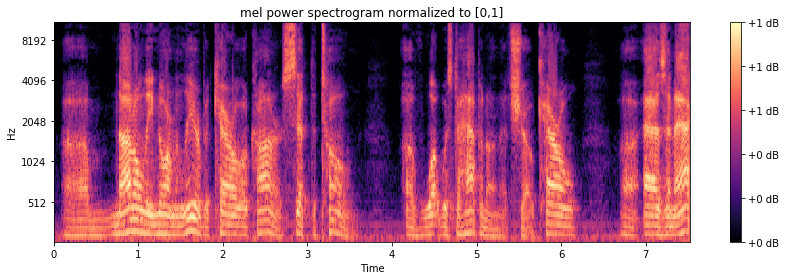

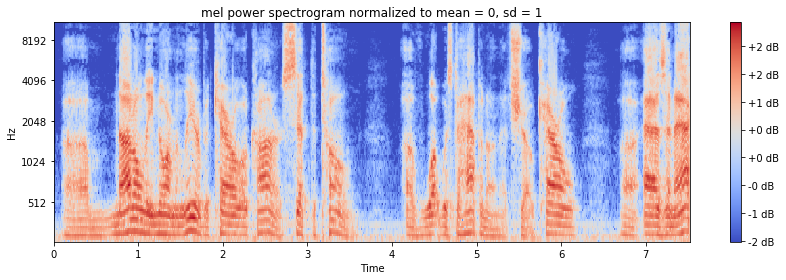

In [8]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

sr = 16000 # sampling rate
n_mels = 128
n_fft = 512
n_hop = 128

def get_audio(audio_path):
    y, _ = librosa.load(audio_path, sr=sr)
    return y

# Spectrogram generation using Kapre https://github.com/keunwoochoi/kapre
def get_spectrogram(audio_path, normalize):
    y = get_audio(audio_path)
    src = np.random.random((1, len(y)))
    model = Sequential()
    model.add(Melspectrogram(sr=sr, n_mels=n_mels, 
          n_dft=n_fft, n_hop=n_hop, input_shape=src.shape, power_melgram=2.0,
          return_decibel_melgram=True,
          trainable_kernel=False, name='melgram'))
    if normalize:
        model.add(Normalization2D(int_axis=0))
    n_ch, nsp_src = model.input_shape[1:]
    #src, _ = librosa.load(audio_path, sr=sr, mono=True)
    y = y[:nsp_src]
    y_batch = y[np.newaxis, np.newaxis, :]
    pred = model.predict(x=y_batch)
    if keras.backend.image_data_format == 'channels_first':
        S = pred[0, 0]
    else:
        S = pred[0, :, :, 0]
    log_S = S
    return log_S

y, _ = librosa.load(audio_path, sr=sr)
log_S = get_spectrogram(audio_path, False)
mn = np.min(log_S)
mx = np.max(log_S)
log_S -= mn
log_S /= (mx - mn)

print(len(y))
print(log_S.shape)
print(log_S)
print(sr)

normalized_log_S = get_spectrogram(audio_path, True);

print(np.max(np.abs(log_S - normalized_log_S)))

# Make a new figure
plt.figure(figsize=(12, 4))    
librosa.display.specshow(log_S, sr=sr, hop_length=n_hop, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram normalized to [0,1]')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Make a new figure
plt.figure(figsize=(12, 4))    
librosa.display.specshow(normalized_log_S, sr=sr, hop_length=n_hop, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram normalized to mean = 0, sd = 1')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


In [9]:
NUM_PEOPLE = 10
AUDIO_LENGTH = 128 * 3 # Around 128 columns in spectrogram is one second
AUDIO_GAP = 128 // 2 # Gap of half a second
audio = []
speaker = []
for idx, name in enumerate(names[:NUM_PEOPLE]):
    print(name)
    num_clips = 0
    for audio_clip in audio_clips[name]:
        base_clip = get_audio('/'.join([VCB_PATH, name, audio_clip]))
        length = base_clip.shape[0]
        for start in range(0, length - AUDIO_LENGTH * n_mels + 1, AUDIO_GAP * n_mels):
            clip = [base_clip[start : start + (AUDIO_LENGTH * n_mels)]]
            audio += [clip]
            speaker += [np.reshape(np.eye(NUM_PEOPLE)[[idx]], NUM_PEOPLE)]

print(len(audio))
print(len(speaker))

Rob_Reiner
Bob_Barker
Alan_Alda
Stephen_Fry
Louis_C.K.
Peter_Jackson
Vince_Gilligan
J.J._Abrams
Quentin_Tarantino
David_Attenborough
60994
60994


In [10]:
n = len(audio)
import random

asdf = list(zip(audio, speaker))
random.shuffle(asdf)
audio, speaker = list(map(list,zip(*asdf)))

In [11]:
train_size = n // 2
val_size = n // 4
audio_train = np.array(audio[:train_size], dtype=float)
print(audio_train.shape)

speaker_train = np.array(speaker[:train_size], dtype=int)
print(speaker_train.shape)

audio_val = np.array(audio[train_size : train_size + val_size], dtype=float)
print(audio_val.shape)

speaker_val = np.array(speaker[train_size : train_size + val_size], dtype=int)
print(speaker_val.shape)

audio_test = np.array(audio[train_size + val_size:], dtype=float)
print(audio_test.shape)

speaker_test = np.array(speaker[train_size + val_size:], dtype=int)
print(speaker_test.shape)

(30497, 1, 49152)
(30497, 10)
(15248, 1, 49152)
(15248, 10)
(15249, 1, 49152)
(15249, 10)


In [14]:
from keras.layers import *

HIDDEN_DIM = 128
LEARNING_RATE = 0.002

model = Sequential()
model.add(Melspectrogram(sr=sr, n_mels=n_mels, 
      n_dft=n_fft, n_hop=n_hop, input_shape=(1, AUDIO_LENGTH * n_mels), 
      return_decibel_melgram=True, power_melgram=2.0,
      trainable_kernel=False, name='melgram'))
model.add(Normalization2D(int_axis=0))
model.add(keras.layers.Reshape((n_mels, AUDIO_LENGTH)))
model.add(Permute((2, 1)))
model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(NUM_PEOPLE, activation='softmax'))
rmsprop = keras.optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy', # loss function to be optimized
              metrics=['accuracy']) # doesn't affect optimization
model.fit(audio_train, speaker_train, validation_data=(audio_val, speaker_val), epochs=5, batch_size=256, shuffle=True)
model.summary()


Train on 30497 samples, validate on 15248 samples
Epoch 1/5
30497/30497 [==============================] - 104s - loss: 0.8915 - acc: 0.7097 - val_loss: 0.6584 - val_acc: 0.7926
Epoch 2/5
30497/30497 [==============================] - 104s - loss: 0.3037 - acc: 0.9070 - val_loss: 0.3121 - val_acc: 0.8993
Epoch 3/5
30497/30497 [==============================] - 104s - loss: 0.1884 - acc: 0.9424 - val_loss: 0.3637 - val_acc: 0.8837
Epoch 4/5
30497/30497 [==============================] - 104s - loss: 0.1265 - acc: 0.9633 - val_loss: 0.0946 - val_acc: 0.9727
Epoch 5/5
30497/30497 [==============================] - 104s - loss: 0.0859 - acc: 0.9739 - val_loss: 0.1569 - val_acc: 0.9462
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 384, 1)       296064    
_________________________________________________________________
normalization2d_5 (Normaliza (None, 128, 384, 

In [43]:
def evaluate(audio, speaker):
    scores = model.predict(audio, batch_size=256)
    return 1.0 * np.sum(np.argmax(scores, axis=1) - np.argmax(speaker, axis=1) == 0) / scores.shape[0]

In [45]:
print("Train:", evaluate(audio_train, speaker_train))

Train: 0.952519919992


In [46]:
print("Val:", evaluate(audio_val, speaker_val))

Val: 0.946156873033


In [47]:
print("Test:", evaluate(audio_test, speaker_test))

Test: 0.947799855728


In [48]:
num_audio_clips = 0
for name in names:
    num_audio_clips += len(audio_clips[name])
print(len(names))
print(num_audio_clips)

1251
153516
